In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

In [3]:
df=pd.read_csv('../data/unusual_drop_preprocess_all_v4.csv')

In [4]:
test_df = pd.read_csv('../data/IRR_preprocess_all_test_v3.csv')

In [5]:
test_df['int_rate'] = test_df['int_rate'].str.rstrip("%").str.strip().astype(float)

In [6]:
with open('../data/selected_cols_v1.txt', 'r', encoding='utf-8') as f:
    selected_cols_v1 = [line.strip() for line in f if line.strip()]

In [7]:
with open('../data/categorical_cols_v1.txt', 'r', encoding='utf-8') as f:
    cat_columns_v1 = [line.strip() for line in f if line.strip() != '']

In [8]:
# 모델에 넣는 변수들 이외 필요한 변수들 확인
df_else = df.drop(selected_cols_v1, axis=1)
df_else = df_else.drop(cat_columns_v1, axis=1)
df_else.head()

,id,installment,int_rate,issue_d,loan_amnt,loan_status,loan_status_label,sub_grade,total_pymnt,treasury,funded_amnt,irr
0,84253847,680.82,24.99,2016-07-01,23200.0,1,연체/부실,E4,8599.680000,0.000889,23200.0,-0.028885
1,119708428,494.55,7.07,2017-10-01,16000.0,1,연체/부실,A2,11804.280000,0.001392,16000.0,-0.016852
2,109906493,146.10,10.42,2017-05-01,4500.0,0,정상상환,B3,5134.174383,0.001228,4500.0,0.008687
3,60286250,645.25,9.99,2015-09-01,20000.0,0,정상상환,B3,23278.037543,0.000841,20000.0,0.008325
4,151871973,482.17,17.97,2019-05-01,19000.0,1,연체/부실,D1,444.230000,0.001805,19000.0,-0.087127


In [9]:
# 모델에 넣는 변수들 이외 필요한 변수들 확인
df_else_test = test_df.drop(selected_cols_v1, axis=1)
df_else_test = df_else_test.drop(cat_columns_v1, axis=1)
df_else_test.head()

,id,installment,int_rate,issue_d,loan_amnt,loan_status,loan_status_label,sub_grade,total_pymnt,mths_since_last_delinq_cat,rcnt_il_cat,mths_since_recent_bc_cat,mths_since_recent_revol_delinq_cat,treasury,funded_amnt,irr
0,3697367,608.72,6.03,2013-03-01,20000.0,0,정상상환,A1,21913.551924,No Record,No Record,1-2yr,No Record,0.000321,20000.0,0.005026
1,13046178,283.22,14.64,2014-03-01,12000.0,1,연체/부실,C3,6001.910000,3-4yr,No Record,1-2yr,3-4yr,0.001356,12000.0,-0.021544
2,69533136,451.73,5.32,2016-02-01,15000.0,0,정상상환,A1,16141.454015,3-4yr,1-2yr,<1yr,No Record,0.000744,15000.0,0.004434
3,6134635,674.37,13.05,2013-08-01,20000.0,0,정상상환,B5,21944.810381,No Record,No Record,<1yr,No Record,0.000585,20000.0,0.010876
4,46705240,381.03,13.99,2015-04-01,11150.0,0,정상상환,C4,13436.829005,No Record,No Record,<1yr,No Record,0.000718,11150.0,0.011659


In [10]:
df_sel = df[selected_cols_v1]

In [11]:
df_sel_test = test_df[selected_cols_v1]

In [12]:
df_cat = df[cat_columns_v1]
df_cat.head()

,addr_state,inq_last_6mths,emp_length,home_ownership,purpose,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,verification_status,grade
0,OK,1,10+ years,MORTGAGE,debt_consolidation,<1yr,unknown,unknown,<1yr,<1yr,<1yr,0,<1yr,Verified,E
1,TX,0,unknown,MORTGAGE,home_improvement,unknown,unknown,unknown,1-2yr,<1yr,unknown,10+,unknown,Not Verified,A
2,FL,0,5 years,MORTGAGE,home_improvement,unknown,unknown,<3yr,2yr+,1-2yr,unknown,6,unknown,Not Verified,B
3,IL,0,10+ years,MORTGAGE,credit_card,3-4yr,4-5yr,unknown,unknown,1-2yr,3-4yr,5,3-4yr,Source Verified,B
4,NC,1,5 years,MORTGAGE,debt_consolidation,unknown,unknown,unknown,1-2yr,1-2yr,unknown,6,unknown,Verified,D


In [13]:
df_cat_test = test_df[cat_columns_v1]
df_cat_test.head()

,addr_state,inq_last_6mths,emp_length,home_ownership,purpose,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,verification_status,grade
0,IN,1.0,6 years,MORTGAGE,debt_consolidation,unknown,unknown,unknown,unknown,1-2yr,unknown,6,unknown,Source Verified,A
1,GA,0.0,< 1 year,RENT,credit_card,3-4yr,3-4yr,6-7yr,unknown,1-2yr,3-4yr,8,3-4yr,Source Verified,C
2,CA,0.0,1 year,MORTGAGE,car,3-4yr,3-4yr,unknown,1-2yr,<1yr,unknown,6,unknown,Not Verified,A
3,MI,1.0,1 year,OWN,debt_consolidation,unknown,unknown,unknown,unknown,<1yr,unknown,3,unknown,Verified,B
4,CA,0.0,3 years,RENT,debt_consolidation,unknown,unknown,unknown,unknown,<1yr,unknown,10+,unknown,Source Verified,C


In [14]:
# 범주형 변수들 -> 원핫인코딩
# columns=cat_columns_v1 (리스트 그대로 전달)
df_cat = pd.get_dummies(df_cat, columns = cat_columns_v1, drop_first=True)

In [15]:
# 범주형 변수들 -> 원핫인코딩
# columns=cat_columns_v1 (리스트 그대로 전달)
df_cat_test = pd.get_dummies(df_cat_test, columns = cat_columns_v1, drop_first=True)

In [16]:
# 연속형 변수와 원핫인코딩 합치기
df_model = pd.concat([df_sel, df_cat], axis=1)

In [17]:
# 연속형 변수와 원핫인코딩 합치기
df_model_test = pd.concat([df_sel_test, df_cat_test], axis=1)

In [18]:
# 모델2의 목적함수는 'irr' 예측하기
X = df_model
meta = df_else[['funded_amnt', 'treasury', 'irr']] # 스케일링 되지 않은 값이 필요
y = df_else['irr']

In [19]:
# 3대 1로 train set, validation set 나누기
X_tr,X_val,y_tr,y_val, meta_tr, meta_val = train_test_split(
    X,y, meta, test_size=0.25, random_state=111
)

In [20]:
# 1. 컬럼명 클린업 함수 정의
def clean_feature_names(df):
    df.columns = (
        df.columns
        .astype(str)
        .str.replace('[', '(', regex=False)
        .str.replace(']', ')', regex=False)
        .str.replace('<', 'lt', regex=False)
        .str.replace('>', 'gt', regex=False)
    )
    return df

# 2. 적용
X_tr = clean_feature_names(X)
X_test = clean_feature_names(df_model_test)

In [21]:
X_test.columns = [col if 'inq_last_6mths' not in col else col.rstrip(".0") for col in X_test.columns ]

Bootstrap indices: 100%|██████████| 1000/1000 [00:11<00:00, 88.97it/s]


Sharpe@0.09: mean=0.1936, std=0.0019


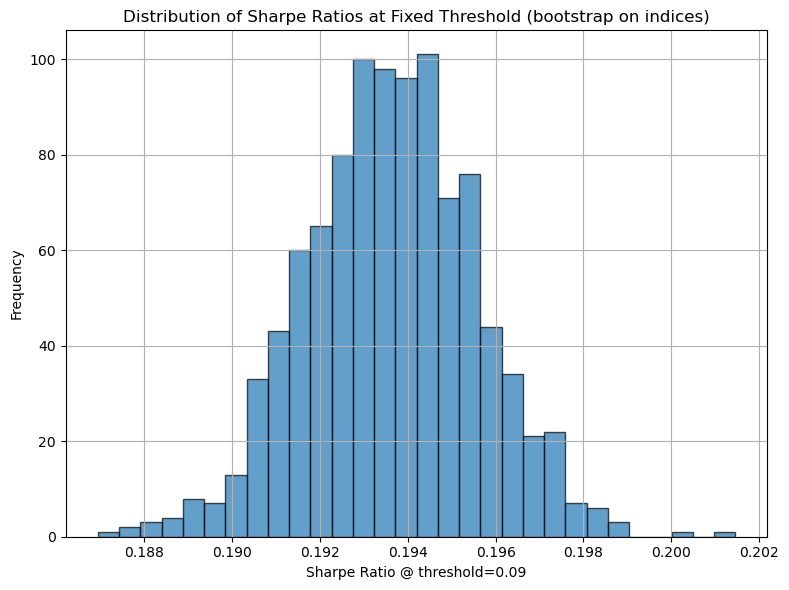

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from tqdm import tqdm

# 1) 전처리 1회
X = clean_feature_names(X)
X_test = clean_feature_names(X_test)

# 2) 모델 1회 학습 (+조기종료/트리수 축소 권장)
model = XGBRegressor(
    n_estimators=100,          # 200 -> 100 (또는 더 줄이기)
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',        # GPU 있으면 'gpu_hist'
    subsample=0.9,
    colsample_bytree=0.9
)
model.fit(X, y, verbose=False)

# 3) 예측 1회 & 정규화
preds_full = model.predict(X_test)
pmin, pmax = preds_full.min(), preds_full.max()
preds_full = 1 - ((preds_full - pmin) / (pmax - pmin + 1e-12))

irr_full = df_else_test['irr'].to_numpy()
rf_full  = df_else_test['treasury'].to_numpy()
# (옵션) default_flag = (df_else_test['loan_status'].to_numpy() == 1)

# 4) 임계값 고정 후, 테스트 인덱스 부트스트랩만 1000회
N_BOOTSTRAP = 1000
TH = 0.09
sharpe_dist = []
n = len(preds_full)

for _ in tqdm(range(N_BOOTSTRAP), desc="Bootstrap indices"):
    idx = np.random.randint(0, n, size=n)  # with replacement

    decisions = (preds_full[idx] > TH).astype(int)  # 0=대출, 1=거절
    irr = irr_full[idx]
    rf  = rf_full[idx]

    returns = np.where(decisions == 0, irr, rf)
    # (옵션) 대출+부도 0 처리:
    # returns = np.where((decisions==0) & default_flag[idx], 0.0, returns)

    excess = returns - rf
    mu, sigma = excess.mean(), excess.std(ddof=0)
    sharpe = mu / sigma if sigma > 0 else -np.inf
    sharpe_dist.append(sharpe)

print(f"Sharpe@{TH}: mean={np.mean(sharpe_dist):.4f}, std={np.std(sharpe_dist):.4f}")

plt.figure(figsize=(8,6))
plt.hist(sharpe_dist, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel(f"Sharpe Ratio @ threshold={TH}")
plt.ylabel("Frequency")
plt.title("Distribution of Sharpe Ratios at Fixed Threshold (bootstrap on indices)")
plt.grid(True)
plt.tight_layout()
plt.show()

Bootstrap indices: 100%|██████████| 1000/1000 [00:12<00:00, 81.04it/s]


Sharpe@0.8385: mean=1.3568, std=0.0017


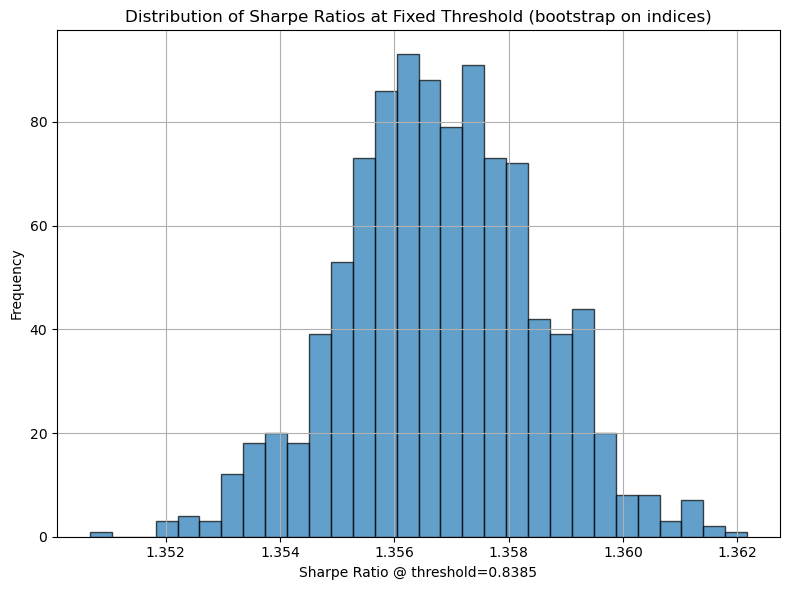

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from tqdm import tqdm

# 1) 전처리 1회
X = clean_feature_names(X)
X_test = clean_feature_names(X_test)

# 2) 모델 1회 학습 (+조기종료/트리수 축소 권장)
model = XGBRegressor(
    n_estimators=100,          # 200 -> 100 (또는 더 줄이기)
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',        # GPU 있으면 'gpu_hist'
    subsample=0.9,
    colsample_bytree=0.9
)
model.fit(X, y, verbose=False)

# 3) 예측 1회 & 정규화
preds_full = model.predict(X_test)
pmin, pmax = preds_full.min(), preds_full.max()
preds_full = 1 - ((preds_full - pmin) / (pmax - pmin + 1e-12))

irr_full = df_else_test['irr'].to_numpy()
rf_full  = df_else_test['treasury'].to_numpy()
# (옵션) default_flag = (df_else_test['loan_status'].to_numpy() == 1)

# 4) 임계값 고정 후, 테스트 인덱스 부트스트랩만 1000회
N_BOOTSTRAP = 1000
TH = 0.8385
sharpe_dist = []
n = len(preds_full)

for _ in tqdm(range(N_BOOTSTRAP), desc="Bootstrap indices"):
    idx = np.random.randint(0, n, size=n)  # with replacement

    decisions = (preds_full[idx] > TH).astype(int)  # 0=대출, 1=거절
    irr = irr_full[idx]
    rf  = rf_full[idx]
    
    default_flag = (df_else_test['loan_status'].to_numpy() == 1)
    returns = np.where(decisions == 0, irr, rf)
    # (옵션) 대출+부도 0 처리:
    returns = np.where((decisions==0) & default_flag[idx], 0.0, returns)

    excess = returns - rf
    mu, sigma = excess.mean(), excess.std(ddof=0)
    sharpe = mu / sigma if sigma > 0 else -np.inf
    sharpe_dist.append(sharpe)

print(f"Sharpe@{TH}: mean={np.mean(sharpe_dist):.4f}, std={np.std(sharpe_dist):.4f}")

plt.figure(figsize=(8,6))
plt.hist(sharpe_dist, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel(f"Sharpe Ratio @ threshold={TH}")
plt.ylabel("Frequency")
plt.title("Distribution of Sharpe Ratios at Fixed Threshold (bootstrap on indices)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# XGBoost 회귀 모델 학습
xgb = XGBRegressor(
    n_estimators=200,  # 트리 개수(적당히 조정)
    max_depth=5,       # 트리 깊이(데이터 상황에 따라)
    learning_rate=0.1, # 러닝레이트
    random_state= 111,
    n_jobs=-1
)
xgb.fit(X_tr, df_else['irr'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
importances = xgb.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_tr.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df.head(15))

                        feature  importance
144  mths_since_rcnt_il_unknown    0.069562
5                      mort_acc    0.032725
105          emp_length_unknown    0.032578
108         home_ownership_RENT    0.025972
15                         term    0.025695
86                addr_state_UT    0.023107
4          acc_open_past_24mths    0.020435
146   mths_since_recent_bc_3yr+    0.011910
94             inq_last_6mths_2    0.011791
155     mths_since_recent_inq_1    0.011291
147  mths_since_recent_bc_lt1yr    0.011281
104        emp_length_lt 1 year    0.010830
174                     grade_B    0.010646
84                addr_state_TN    0.009585
55                addr_state_ID    0.009009


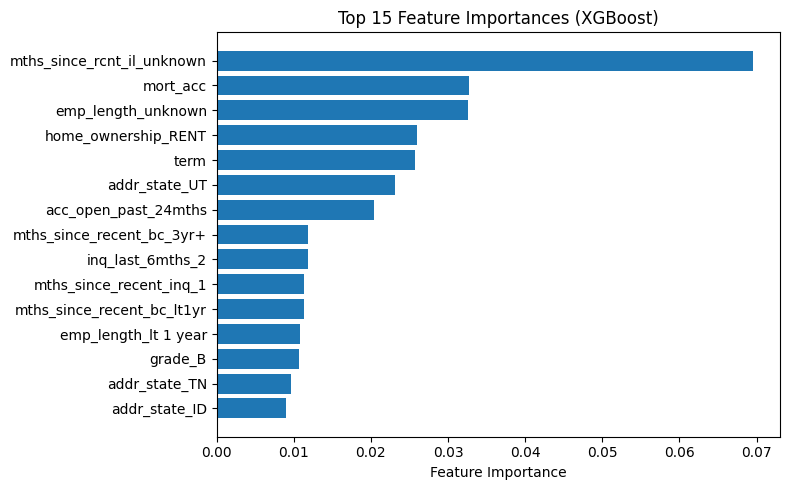

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(importance_df['feature'][:15], importance_df['importance'][:15])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

In [ ]:
# 모델 불러오고, fit하고 예측하는 순서대로 진행됨
y_val_pred = xgb.predict(X_test)

# 1. min-max scaling
y_val_pred_min_max = (y_val_pred - y_val_pred.min()) / (y_val_pred.max() - y_val_pred.min())

# 2. 좌우반전 (이후 sharpe ratio 구할 때 맞춰주기 위함)
y_val_pred = 1 - y_val_pred_min_max

(array([7.80000e+01, 1.85990e+04, 2.86310e+05, 2.81597e+05, 9.83250e+04,
        2.47160e+04, 5.77200e+03, 1.32600e+03, 2.49000e+02, 1.17000e+02,
        6.20000e+01, 4.40000e+01, 2.80000e+01, 1.90000e+01, 1.30000e+01,
        8.00000e+00, 7.00000e+00, 2.00000e+00, 3.00000e+00, 3.00000e+00,
        1.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.        , 0.03333334, 0.06666667, 0.10000001, 0.13333334,
        0.16666667, 0.20000002, 0.23333335, 0.26666668, 0.30000001,
        0.33333334, 0.36666667, 0.40000004, 0.43333337, 0.4666667 ,
        0.5       , 0.53333336, 0.56666672, 0.60000002, 0.63333338,
        0.66666669, 0.70000005, 0.73333335, 0.76666671, 0.80000007,
        0.83333337, 0.86666673, 0.90000004, 0.9333334 , 0.9666667 ,
        1.        ]),
 <BarContainer object of 30 artists>)

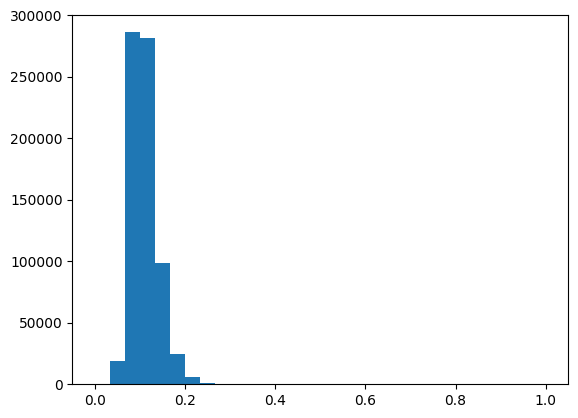

In [ ]:
# 좌우반전 y_val_pred 분포
plt.hist(y_val_pred, bins=30)

In [ ]:
# 회귀 예측값을 threshold 이상이면 1(=> 대출 안 해줌), 아니면 0(=> 대출해줌)으로 간주
val_binary = (y_val_pred > 0.09).astype(int)
val_return = []
for pred, actual, irr, treasury in zip(val_binary, df_else_test['loan_status'], df_else_test['irr'], df_else_test['treasury']):
    if pred == 0:
        val_return.append(irr)
    else:
        val_return.append(treasury)
val_return = np.array(val_return)
risk_free = np.array(df_else_test['treasury'])
excess_ret = val_return - risk_free
if excess_ret.std() > 0:
    sharpe = excess_ret.mean() / excess_ret.std()
else:
    sharpe = np.nan
print(sharpe)

0.1941665093014487


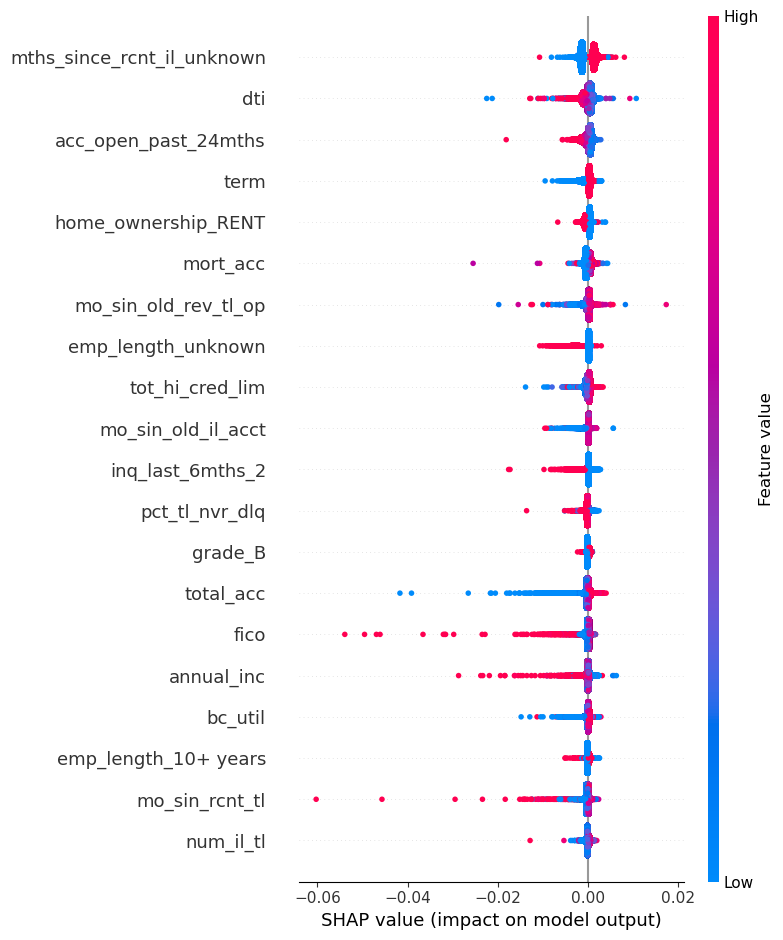

In [ ]:
# X에 있는 독립변수들은 각각 irr 예측값에 얼마나 영향력이 있는가?
# 'irr 예측값'에 대한 영향력임을 유의!!
# shap는 모델의 독립변수-종속변수에 대한 Shapley value를 지원할 뿐,
# 지금의 경우는 sharpe ratio가

import shap

# 1. explainer 객체 생성 (트리계열은 TreeExplainer 사용)
explainer = shap.Explainer(xgb_final)  # model은 xgb, rf, cbr 등 이미 학습된 모델

# 2. shap 값 계산
shap_values = explainer(X_total)

# 3. 요약 시각화 (변수별 shapley value의 분포)
shap.summary_plot(shap_values, X_total, plot_type='dot', show=True)
